* Sacred Objectからちゃんとデータを取り出す（普通にDone）
* Sacred Objectを使って，アーチファクトを取り出す（Artifactは，正直形式がわからないので使わない．_run['info']['log_dir']を記録しておいて，普通にファイルパスで読み取る
* 既にやってた実験をSacredの方に入れ込む方法を考える
  (これはSacredのUI使う方が多分やりやすい）

### 評価用のコード


In [22]:
from sacred_wrap import SacredRecords
from sacred_wrap import MongoExtractor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/root/.pyenv/versions/3.6.3/envs/pytorch/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [23]:
# # -*- coding: utf-8 -*-
import itertools
import numpy as np

import sacred_wrap as sw  # utils specific for the usage of sacred
import utils
from collections import OrderedDict


def get_config_from_code(code):
    # base configurations
    base = {
        'hidden': 1600, 
        'context': 800, 
        'num_gru': 1
    }
    # Baselines
    method_dict = {
        'CPC-random': {'name': 'CPC', 'sampler_mode': 'random'}, 
        'CPC-diff': {'name': 'CPC', 'sampler_mode': 'diff'},
        'CPC-same': {'name': 'CPC', 'sampler_mode': 'same'},
        'VAE': {'name': 'VAE', 'sampler_mode': 'random'}, 
    }    
    
    base.update(method_dict.get(code))
    return base


def get_dataset_config(code):
    name, test_domain = code.split('-')
    del code
    return locals()


def get_optim_config(dataset_code, method_code):
    optim_config = {}
    return optim_config


def get_base_config(dataset_code, method_code):
    dataset_config = get_dataset_config(dataset_code)
    method_config = get_config_from_code(method_code)
    optim_config = get_optim_config(dataset_code, method_code)
    return {'dataset': dataset_config, 'method': method_config, 'optim': optim_config}
    
    
def get_summary(dataset_names, method_hypara_dict, seed=None, fields=None, db_name='CPC_test'):
    summary = sw.SacredRecords()
    for dataset_name, method_name in itertools.product(dataset_names, method_hypara_dict.keys()):
        config = get_base_config(dataset_name, method_name)
        config = utils.flatten_dict(config)

        config.update(method_hypara_dict[method_name])
        print(config)
        if seed is not None:
            config['seed'] = seed
        df = sw.SacredRecords.from_mongo(config, db_name=db_name, fields=fields)
        df['dataset'] = dataset_name
        df['method'] = method_name

        summary = summary.append(df, sort=False)
    return summary

In [24]:
def nanarray(size):
    array = np.zeros(size)
    array[...] = np.nan
    return array


def get_mean_score(_filtered, metric):
    metric_values = np.array(list(_filtered[metric]))
    max_length = max([len(x) for x in np.array(list(metric_values))])
    metric_mean = np.nanmean( np.array([np.concatenate([np.array(x), nanarray(max_length-len(x))]) for x in list(metric_values)]), axis=0)
    return metric_mean


def plot_value_of_metric(summary, hypara_name, metric, ax=None, linetype='-'):
        
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        
    if hypara_name is None:
        metric_mean = get_mean_score(summary, metric)
        ax.plot(metric_mean, linetype)

    else:
        hypara_values = summary[hypara_name].unique()
        for hypara_value in hypara_values:
            # the both two values have shape (k, m) where k is #trial and m is #steps for measuring the metric
            # Note: np.array(list(x)) operation seems odd, but it is due to the format of the summary (sacred format)
            _filtered = summary[summary[hypara_name]==hypara_value]
            metric_mean = get_mean_score(_filtered, metric)
            ax.plot(metric_mean, linetype, label=hypara_value)
    if 'fig' in locals():
        return fig, ax
    return ax

In [25]:
dataset_names = [
    'oppG-S1'
]

method_hypara_dict = OrderedDict()
method_hypara_dict['CPC-random'] = {'dataset.L': 12, 'dataset.K': 5}
method_hypara_dict['CPC-diff'] = {'dataset.L': 12, 'dataset.K': 5}
method_hypara_dict['CPC-same'] = {'dataset.L': 12, 'dataset.K': 5}

summary = get_summary(dataset_names, method_hypara_dict, seed=[123456], fields=None, db_name='CPC_test')

{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': 1600, 'method.context': 800, 'method.num_gru': 1, 'method.name': 'CPC', 'method.sampler_mode': 'random', 'dataset.L': 12, 'dataset.K': 5}
{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': 1600, 'method.context': 800, 'method.num_gru': 1, 'method.name': 'CPC', 'method.sampler_mode': 'diff', 'dataset.L': 12, 'dataset.K': 5}
{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': 1600, 'method.context': 800, 'method.num_gru': 1, 'method.name': 'CPC', 'method.sampler_mode': 'same', 'dataset.L': 12, 'dataset.K': 5}


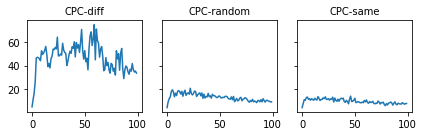

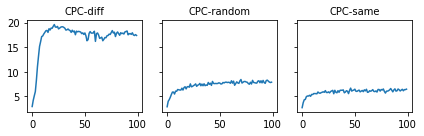

In [26]:
dataset = dataset_names[0]
method_indicator = ['method']

grouped = summary.query('dataset==@dataset').groupby(method_indicator)
fig, axes = plt.subplots(1, len(grouped), figsize=(2*len(grouped), 2), sharey=True)
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, None, 'valid-cmdg', ax=ax)
    # ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()

fig, axes = plt.subplots(1, len(grouped), figsize=(2*len(grouped), 2), sharey=True)
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, None, 'valid-cmdc', ax=ax)
    # ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()
    

In [27]:
dataset_names = [
    'oppG-S1'
]

method_hypara_dict = OrderedDict()
method_hypara_dict['CPC-random'] = {'dataset.L': 12, 'dataset.K': 5, 'method.context': None, 'method.hidden':None, 'method.num_gru': None}
method_hypara_dict['CPC-diff'] = {'dataset.L': 12, 'dataset.K': 5, 'method.context':None, 'method.hidden': None, 'method.num_gru': None}
method_hypara_dict['CPC-same'] = {'dataset.L': 12, 'dataset.K': 5, 'method.context':None, 'method.hidden': None, 'method.num_gru': None}

summary = get_summary(dataset_names, method_hypara_dict, seed=[123456], fields=None, db_name='CPC_test')

{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': None, 'method.context': None, 'method.num_gru': None, 'method.name': 'CPC', 'method.sampler_mode': 'random', 'dataset.L': 12, 'dataset.K': 5}
{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': None, 'method.context': None, 'method.num_gru': None, 'method.name': 'CPC', 'method.sampler_mode': 'diff', 'dataset.L': 12, 'dataset.K': 5}
{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': None, 'method.context': None, 'method.num_gru': None, 'method.name': 'CPC', 'method.sampler_mode': 'same', 'dataset.L': 12, 'dataset.K': 5}


### 教師あり学習

In [69]:
def get_sup_config(code):
    dic = OrderedDict()
    dic['P'] = {'classifier.pretrain': True, 'classifier.finetune_g': False, 'classifier.use_c_enc': False, 'classifier.finetune_c': False}
    dic['F'] = {'classifier.pretrain': True, 'classifier.finetune_g': True, 'classifier.use_c_enc': False, 'classifier.finetune_c': False}
    dic['S'] = {'classifier.pretrain': False, 'classifier.finetune_g': True, 'classifier.use_c_enc': False, 'classifier.finetune_c': False}
    dic['R'] = {'classifier.pretrain': False, 'classifier.finetune_g': False, 'classifier.use_c_enc': False, 'classifier.finetune_c': False}
    dic['PC'] = {'classifier.pretrain': True, 'classifier.finetune_g': False, 'classifier.use_c_enc': True, 'classifier.finetune_c': False}
    dic['FC'] = {'classifier.pretrain': True, 'classifier.finetune_g': False, 'classifier.use_c_enc': True, 'classifier.finetune_c': True}
    dic['FG'] = {'classifier.pretrain': True, 'classifier.finetune_g': True, 'classifier.use_c_enc': True, 'classifier.finetune_c': False}
    dic['FGC'] = {'classifier.pretrain': True, 'classifier.finetune_g': True, 'classifier.use_c_enc': True, 'classifier.finetune_c': True}
    dic['SC'] = {'classifier.pretrain': False, 'classifier.finetune_g': False, 'classifier.use_c_enc': True, 'classifier.finetune_c': True}
    dic['SG'] = {'classifier.pretrain': False, 'classifier.finetune_g': True, 'classifier.use_c_enc': True, 'classifier.finetune_c': False}
    dic['SGC'] = {'classifier.pretrain': False, 'classifier.finetune_g': True, 'classifier.use_c_enc': True, 'classifier.finetune_c': True}
    return dic.get(code)

def get_sup_code(s):
    key = ['classifier.pretrain', 'classifier.finetune_g', 'classifier.use_c_enc', 'classifier.finetune_c']
    # for code in ['P', 'F', 'S', 'R']:
    for code in ['P', 'F', 'S', 'R', 'PC', 'FC', 'FG', 'FGC', 'SC', 'SG', 'SGC']:
        if get_sup_config(code) == dict(s[key]):
            return code
    return 'Unknown'

In [70]:
dataset_names = [
    'oppG-S1'
]

method_hypara_dict = OrderedDict()
method_hypara_dict['CPC-random'] = {'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000, 'classifier.auxiliary': 0.0}
method_hypara_dict['CPC-diff'] = {'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000} #, 'classifier.auxiliary': 0.0}
method_hypara_dict['CPC-same'] = {'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000} #, 'classifier.auxiliary': 0.0}
# method_hypara_dict['CPC-same'] = {'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000, 'classifier.auxiliary': 1.0}
method_hypara_dict['VAE'] = {'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000, 'classifier.auxiliary': 0.0}



summary = get_summary(dataset_names, method_hypara_dict, seed=[123456], fields=None, db_name='CPC_DG')
summary['supcode'] = summary.apply(lambda x: get_sup_code(x), axis=1)
summary['classifier.hiddens'] = summary['classifier.hiddens'].fillna(0)


{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': 1600, 'method.context': 800, 'method.num_gru': 1, 'method.name': 'CPC', 'method.sampler_mode': 'random', 'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000, 'classifier.auxiliary': 0.0}
{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': 1600, 'method.context': 800, 'method.num_gru': 1, 'method.name': 'CPC', 'method.sampler_mode': 'diff', 'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000}
{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': 1600, 'method.context': 800, 'method.num_gru': 1, 'method.name': 'CPC', 'method.sampler_mode': 'same', 'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000}
{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': 1600, 'method.context': 800, 'method.num_gru': 1, 'method.name': 'VAE', 'method.sampler_mode': 'random', 'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch'

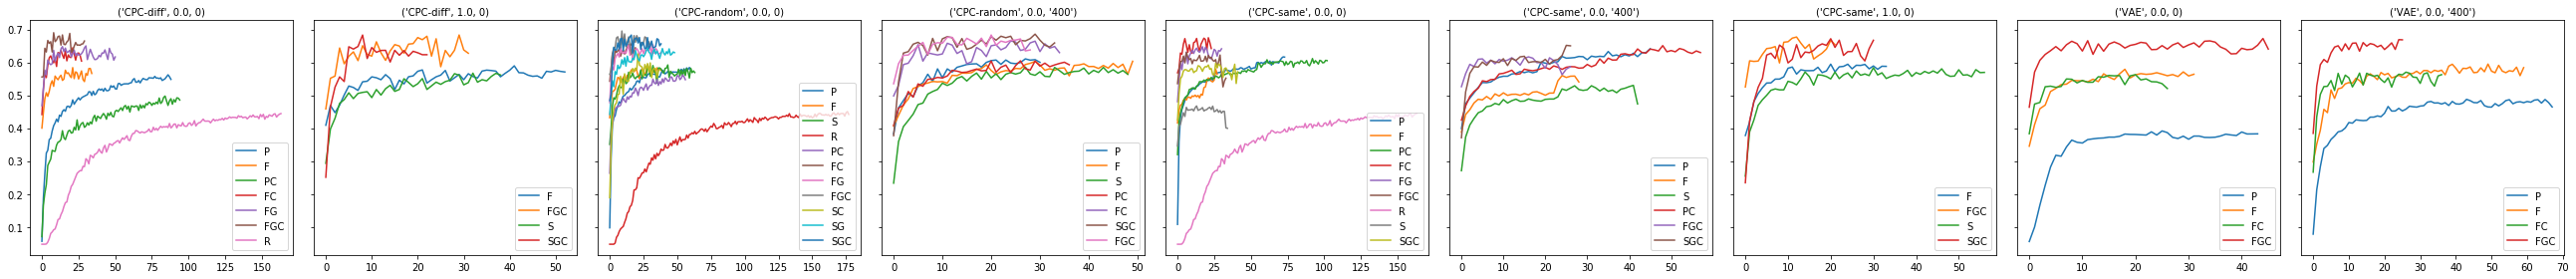

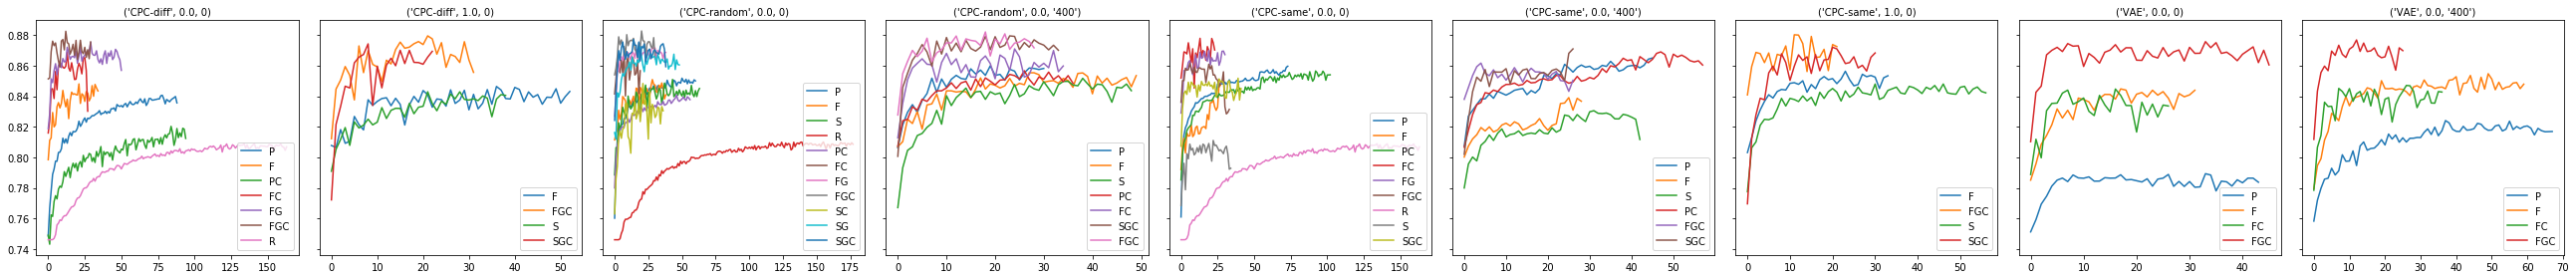

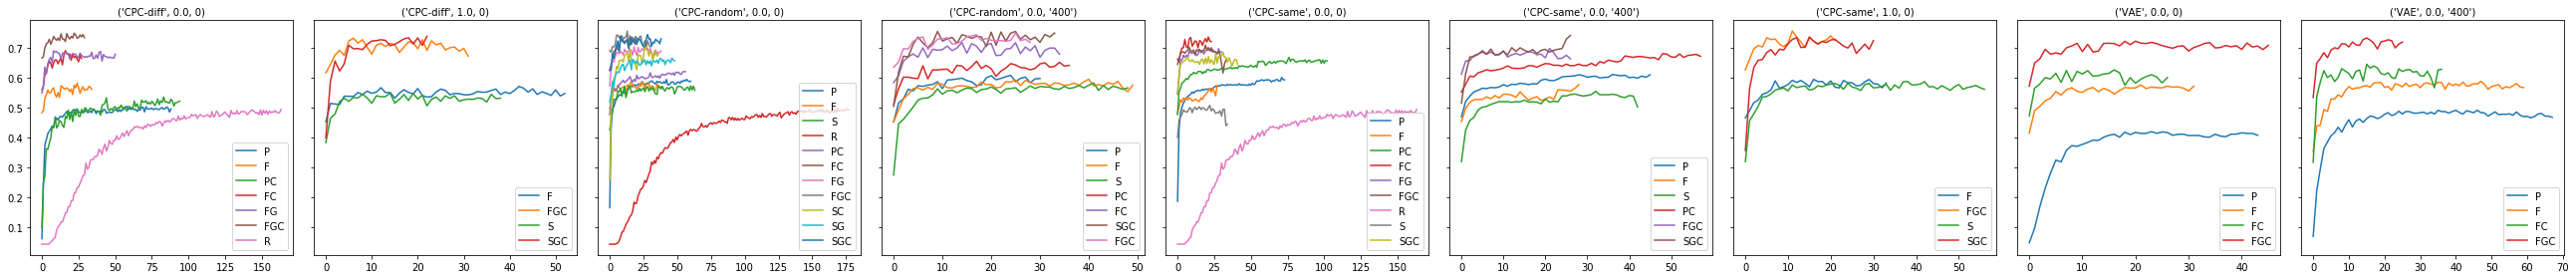

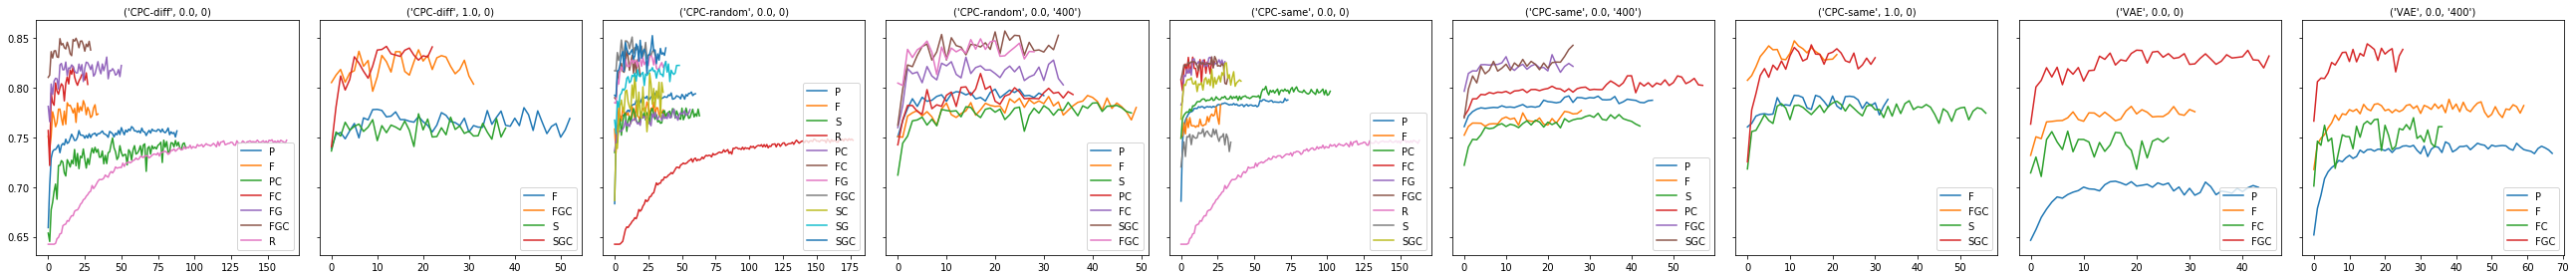

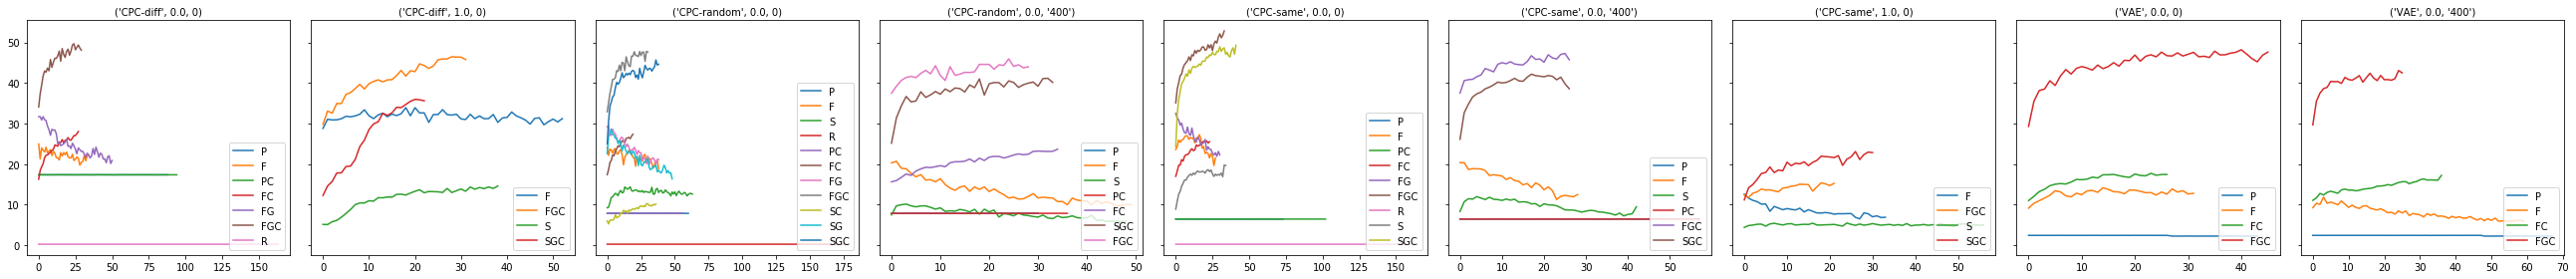

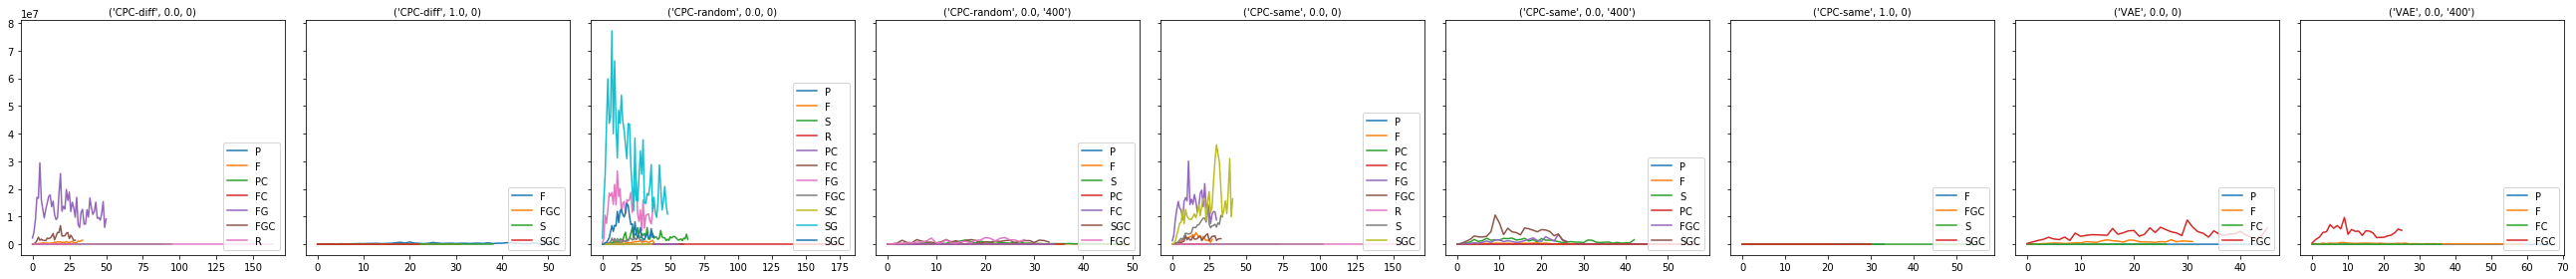

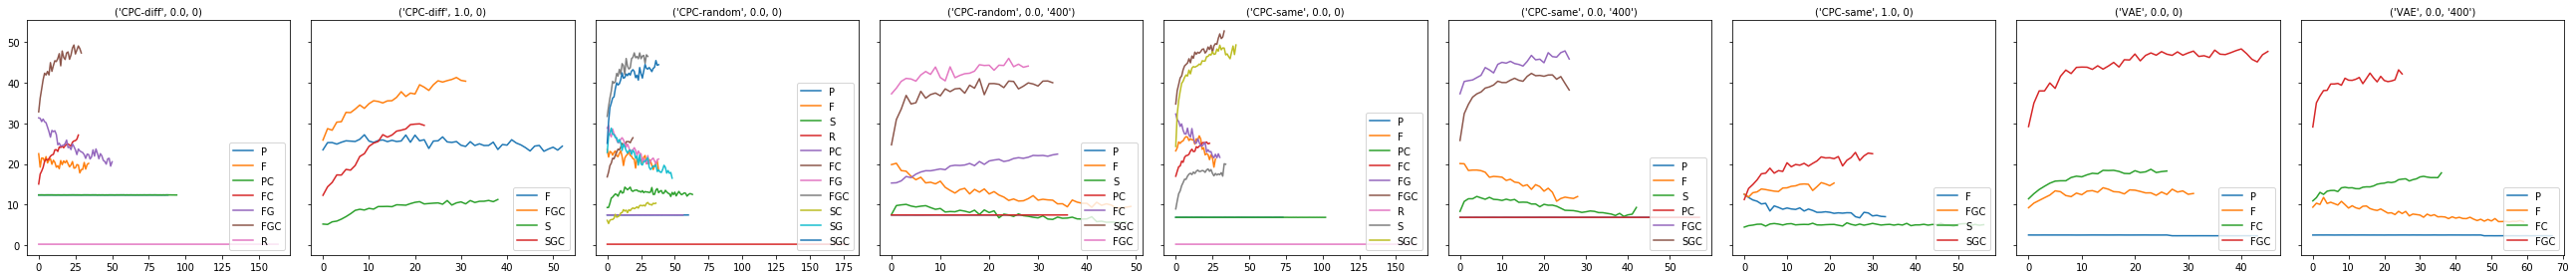

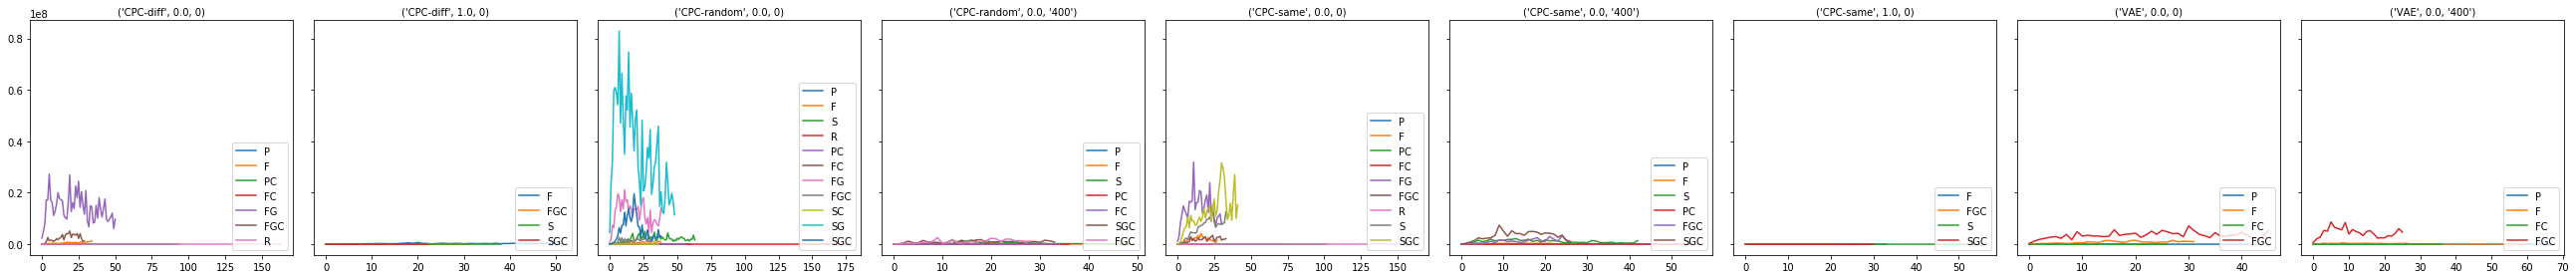

In [71]:
dataset = dataset_names[0]
method_indicator = ['method', 'classifier.auxiliary', 'classifier.hiddens']
grouped = summary.query('dataset==@dataset').groupby(method_indicator)


fig, axes = plt.subplots(1, len(grouped), figsize=(4*len(grouped), 4), sharey=True)
if len(grouped) == 1:
    axes = [axes]
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, 'supcode', 'valid-f1macro', ax=ax)
    ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()

fig, axes = plt.subplots(1, len(grouped), figsize=(4*len(grouped), 4), sharey=True)
if len(grouped) == 1:
    axes = [axes]
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, 'supcode', 'valid-accuracy', ax=ax)
    ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()

fig, axes = plt.subplots(1, len(grouped), figsize=(4*len(grouped), 4), sharey=True)
if len(grouped) == 1:
    axes = [axes]
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, 'supcode', 'test-f1macro', ax=ax)
    ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()

fig, axes = plt.subplots(1, len(grouped), figsize=(4*len(grouped), 4), sharey=True)
if len(grouped) == 1:
    axes = [axes]
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, 'supcode', 'test-accuracy', ax=ax)
    ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()

fig, axes = plt.subplots(1, len(grouped), figsize=(4*len(grouped), 4), sharey=True)
if len(grouped) == 1:
    axes = [axes]
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, 'supcode', 'valid-cmdc', ax=ax)
    ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()

fig, axes = plt.subplots(1, len(grouped), figsize=(4*len(grouped), 4), sharey=True)
if len(grouped) == 1:
    axes = [axes]
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, 'supcode', 'valid-cmdg', ax=ax)
    ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()

fig, axes = plt.subplots(1, len(grouped), figsize=(4*len(grouped), 4), sharey=True)
if len(grouped) == 1:
    axes = [axes]
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, 'supcode', 'test-cmdc', ax=ax)
    ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()

fig, axes = plt.subplots(1, len(grouped), figsize=(4*len(grouped), 4), sharey=True)
if len(grouped) == 1:
    axes = [axes]
for (key, group), ax in zip(grouped, axes):
    plot_value_of_metric(group, 'supcode', 'test-cmdg', ax=ax)
    ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()

### モデルのハイパラごとに比較　

In [44]:
dataset_names = [
    'oppG-S1'
]

method_hypara_dict = OrderedDict()
method_hypara_dict = OrderedDict()
method_hypara_dict['CPC-random'] = {'dataset.L': 12, 'dataset.K': 5, 'method.context': None, 'method.hidden': None, 'method.num_gru': None, 'classifier_optim.num_batch': 30000}
method_hypara_dict['CPC-diff'] = {'dataset.L': 12, 'dataset.K': 5, 'method.context': None, 'method.hidden': None, 'method.num_gru': None, 'classifier_optim.num_batch': 30000}
method_hypara_dict['CPC-same'] = {'dataset.L': 12, 'dataset.K': 5, 'method.context': None, 'method.hidden': None, 'method.num_gru': None, 'classifier_optim.num_batch': 30000}

summary = get_summary(dataset_names, method_hypara_dict, seed=[123456], fields=None, db_name='CPC_DG')
summary['supcode'] = summary.apply(lambda x: get_sup_code(x), axis=1)
summary['classifier.hiddens'] = summary['classifier.hiddens'].fillna(0)
summary = summary[summary['classifier.hiddens'] == 0]

{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': None, 'method.context': None, 'method.num_gru': None, 'method.name': 'CPC', 'method.sampler_mode': 'random', 'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000}
{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': None, 'method.context': None, 'method.num_gru': None, 'method.name': 'CPC', 'method.sampler_mode': 'diff', 'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000}
{'dataset.test_domain': 'S1', 'dataset.name': 'oppG', 'method.hidden': None, 'method.context': None, 'method.num_gru': None, 'method.name': 'CPC', 'method.sampler_mode': 'same', 'dataset.L': 12, 'dataset.K': 5, 'classifier_optim.num_batch': 30000}


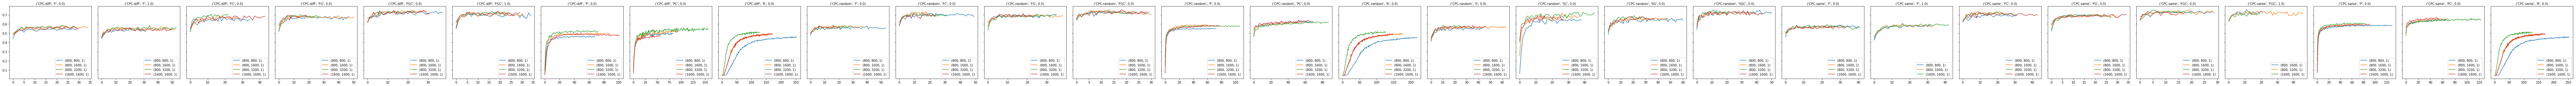

In [46]:
dataset = dataset_names[0]
method_indicator = ['method', 'supcode', 'classifier.auxiliary']

grouped = summary.query('dataset==@dataset').groupby(method_indicator)
fig, axes = plt.subplots(1, len(grouped), figsize=(4*len(grouped), 4), sharey=True)
if len(grouped) == 1:
    axes = [axes]
    
metric = 'test-f1macro'
for (key, group), ax in zip(grouped, axes):
    sub_grouped = group.groupby(['method.context', 'method.hidden', 'method.num_gru'])
    for (sub_key, sub_group) in sub_grouped:
        metric_mean = get_mean_score(sub_group, metric)
        ax.plot(metric_mean, '-', label=sub_key)

    ax.legend(fontsize=10, loc=4, frameon=True)
    ax.set_title(key, size=10)
fig.tight_layout()


* 全体的に、Gを教師ありで訓練する場合と比較して、Gを再学習しない場合はモデル容量による影響が大きい
* 基本的に全部再学習 >= 事前学習無しで全部学習 > 事前学習固定

### 学習用のスクリプト

In [56]:
from datasets import OppG
from utils import split_dataset


def get_dataset(name, validation, test_domain, L, K):
    """Prepare datasets for train, valid and test with configurations.

    Parameter
    ---------
    name : str
    validation : str or list
    test_domain : str or list
    L : int
    K : int

    Return
    ------
    {train/valid}_dataset_{joint/marginal} : torch.Dataset
        {train/valid} datasets from {joint/marginal} distributions
    """
    if isinstance(validation, str):
        validation = validation.split('-')
    all_adls = OppG.get('all_adls')
    all_domain = OppG.get('all_domain_key')
    train_adls = sorted(list(set(all_adls) - set(validation)))
    train_domain = sorted(list(set(all_domain) - set([test_domain])))
    train_dataset_joint = OppG(
        train_domain, l_sample=30, interval=15, T=K+L, adl_ids=train_adls)
    valid_dataset_joint = OppG(
        train_domain, l_sample=30, interval=15, T=K+L, adl_ids=validation)

    # marginal sample come from same datasets for simplicity
    # Same train-valid split with joint dataset
    train_dataset_marginal = OppG(
        train_domain, l_sample=30, interval=15, T=K, adl_ids=train_adls)
    valid_dataset_marginal = OppG(
        train_domain, l_sample=30, interval=15, T=K, adl_ids=validation)
    test_dataset = OppG(test_domain, l_sample=30, interval=15, T=K+L)
    
    return train_dataset_joint, valid_dataset_joint, train_dataset_marginal, valid_dataset_marginal, test_dataset


In [256]:
df = sw.SacredRecords.from_mongo({'method.sampler_mode': 'diff'}, db_name='CPC_DG')
df[['method.sampler_mode', 'method.hidden', 'method.context', 'dataset.K', 'dataset.L', 'method.num_gru']]

,method.sampler_mode,method.hidden,method.context,dataset.K,dataset.L,method.num_gru
0,diff,400,200,5,12,1
1,diff,400,200,5,12,1
2,diff,400,200,5,12,1
3,diff,800,200,5,12,1
4,diff,800,200,5,12,1
5,diff,800,200,5,12,1
6,diff,3200,200,5,12,1


In [61]:
import utils

In [62]:
train_utils.split_dataset(train_dataset, train_size=0.2, shuffle=True, drop_first=False)

(<utils.Subset at 0x7f903d8aa160>, <utils.Subset at 0x7f903d78a278>)

In [67]:
import torch
from utils import split_dataset


def get_split_datasets(dataset, split_size):
    datasets1 = []
    datasets2 = []
    dataset_class = dataset.__class__
    domain_keys = dataset.domain_keys

    for domain_key in domain_keys:
        single_dataset = dataset.get_single_dataset(domain_key, **dataset.domain_specific_params())
        dataset1, dataset2 = split_dataset(single_dataset, split_size, shuffle=True, drop_first=False)
        datasets1.append(dataset1)
        datasets2.append(dataset2)

    datasets1 = dataset_class(domain_keys=domain_keys, datasets=datasets1, **dataset.domain_specific_params())
    datasets2 = dataset_class(domain_keys=domain_keys, datasets=datasets2, **dataset.domain_specific_params())
    return datasets1, datasets2

In [68]:
get_split_datasets(train_dataset, 0.2)

(<datasets.OppG at 0x7f9036039198>, <datasets.OppG at 0x7f903d8b8828>)

In [32]:
from utils import flatten_dict
extractor = MongoExtractor(None, 'CPC_test')
query = {'dataset': {'name': 'oppG', 'validation': 'ADL4-ADL5', 'test_domain': 'S1', 'L': 12, 'K': 5}, 'method': {'name': 'CPC', 'hidden': 1600, 'context': 200, 'num_gru': 1}, 'optim': {'lr': 0.0001, 'num_batch': 100, 'batch_size': 128}}
query = flatten_dict(query)
for result in extractor.find(query, ['config', 'info'], False, 'COMPLETED'):
    print("ok")

ok


In [33]:
from datasets import OppG
from opportunity import Encoder, ContextEncoder, Predictor

In [34]:
_config = result['config']
classifier = {
    'pretrain': True, 
    'finetune_g': False, 
    'use_c_enc': False, 
    'finetune_c': False, 
}

classifier_optim = {
    'lr': 0.001, 
    'num_batch': 10000, 
    'batch_size': 128,
    'monitor_per': 100, 
}
_config['classifier'] = classifier
_config['classifier_optim'] = classifier_optim

In [35]:
import os
import datetime
from copy import deepcopy

import torch
from torch import nn
from torch import optim
from torch.utils import data
from tensorboardX import SummaryWriter

from run_sacred import get_model, get_dataset

In [36]:
from label_predict import Classifier

def get_classifier(model, finetune_g, use_c_enc, finetune_c, **kwargs):
    if use_c_enc:
        classifier = Classifier(
            num_classes=train_dataset.get('num_classes'),
            g_enc=model.g_enc, c_enc=model.c_enc, finetune_g=finetune_g, finetune_c=finetune_c).cuda()
    else:
        classifier = Classifier(
            num_classes=train_dataset.get('num_classes'),
            g_enc=model.g_enc, finetune_g=finetune_g).cuda()
    return classifier

In [37]:
train_dataset, valid_dataset, _, _, test_dataset = get_dataset(**_config['dataset'])
train_loader = data.DataLoader(train_dataset, batch_size=_config['classifier_optim']['num_batch'], shuffle=True)


In [38]:
model = get_model(input_shape=train_dataset.get('input_shape'), K=_config['dataset']['K'], **_config['method'])
if _config['classifier']['pretrain']:
    search_config = deepcopy(_config)
    del search_config['classifier']
    del search_config['classifier_optim']
    extractor = MongoExtractor(None, _config['db_name'])
    # TODO: Should check whether the len(list) is one or not
    result = list(extractor.find(search_config, ['config', 'info'], False, 'COMPLETED'))[0]
    path = os.path.join(result['info']['log_dir'], 'model_{}.pth'.format(_config['optim']['num_batch']))
    model.load_state_dict(torch.load(path))

1600 200


In [39]:
model

CPCModel(
  (g_enc): Encoder(
    (feature): Sequential(
      (0): Conv2d(1, 50, kernel_size=(1, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 40, kernel_size=(1, 5), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(40, 20, kernel_size=(1, 3), stride=(1, 1))
      (7): ReLU()
      (8): Dropout(p=0.5)
      (9): Flatten()
      (10): Linear(in_features=4520, out_features=1600, bias=True)
      (11): ReLU()
      (12): Dropout(p=0.5)
    )
  )
  (c_enc): ContextEncoder(
    (gru): GRU(1600, 200)
  )
  (predictor): Predictor(
    (linears): ModuleList(
      (0): Linear(in_features=200, out_features=1600, bias=True)
      (1): Linear(in_features=200, out_features=1600, bias=True)
      (2): Linear(in_features=200, out_features=1600, bias=True)
      (3): Linear(in_features=200, out_f

### calculate domain invariance

In [96]:
import itertools
from torch.utils import data


def l2diff(x1, x2):
    """
    standard euclidean norm
    """
    return ((x1-x2)**2).sum().sqrt()


def moment_diff(sx1, sx2, k):
    """
    difference between moments
    """
    ss1 = (sx1**k).mean(0)
    ss2 = (sx2**k).mean(0)
    return l2diff(ss1, ss2)


class CMD(object):
    def __init__(self, n_moments=5):
        self.n_moments = n_moments

    def __call__(self, x1, x2):
        mx1 = x1.mean(dim=0)
        mx2 = x2.mean(dim=0)
        sx1 = x1 - mx1
        sx2 = x2 - mx2
        dm = l2diff(mx1, mx2)
        scms = dm

        for i in range(self.n_moments-1):
            # moment diff of centralized samples
            scms += moment_diff(sx1, sx2, i+2)
        return scms


def pairwise_divergence(datasets, func, criterion, batch_size=128, num_batch=None):
    divergence = 0
    num_total_batch = 0
    if num_batch is None:
        num_batch = max([len(dataset) for dataset in datasets])

    for dataset1, dataset2 in itertools.combinations(datasets, 2):
        loader1 = data.DataLoader(dataset1, shuffle=False, batch_size=batch_size)
        loader2 = data.DataLoader(dataset2, shuffle=False, batch_size=batch_size)

        for num_iter, ((X1, Y1), (X2, Y2)) in enumerate(zip(loader1, loader2)):
            divergence += criterion(func(X1.float().cuda()), func(X2.float().cuda())).item()
            if ((num_iter+1) % num_batch) == 0:
                break
        num_total_batch += (num_iter+1)
    return divergence/num_total_batch


def get_feature_of(g_enc, c_enc, L):
    def _func(X):
        if c_enc is None:
            return g_enc(X[..., L-1])
        else:
            return get_context(X[..., :(L-1)], g_enc, c_enc)
    return _func

In [97]:
divergence_criterion = CMD(n_moments=5)
get_g_of = get_feature_of(model.g_enc, None, _config['dataset']['L'])

In [101]:
%time pairwise_divergence(train_dataset.datasets[:2], get_g_of, divergence_criterion, num_batch=10)

CPU times: user 35.5 s, sys: 676 ms, total: 36.2 s
Wall time: 4.47 s


4.290335929393768

In [43]:
def label_predict(
        L, K, g_enc_size, context_size, num_gru, pretrain,  # parameters for model
        finetune_g, use_c_enc=False, finetune_c=False,
        num_batch=10000, iteration_at=10000):
    """Train label classifier.

    TODO: should be separate out the data loading function and classifier building function.
    This function should be focus on the training given classifier with given configurations
    (like datasets or hyperparameters). The name might be just a train() then.

    The ideal argments migth be similar to validate_label_prediction function, with additional
    arguments for hyperparameters.

    Parameter
    ---------
    pretrain : bool
        wheter use CPC pretrained model.
    finetune_g : bool
        wheter train g_encoder.
    use_c_func : bool (default False)
        wheter use context encoder (autoregressive encoder summarize several inputs).
    finetune_c : bool (default False)
        wheter train context encoder. It should be false if use_c_func is False, and True
        if use_c_func and finetune_g is both True.


    Example
    -------
    Case1: pretrain=True and finetune_g=False
    => Shallow classifier over unsupervisly learned representations
    Case2: pretrain=False and finetune_g=True
    => Fully supervised learning
    Case3: pretrain=True and finetune_g=True
    => Unsup+Sup learning
    Case4: pretrain=False and finetune_g=False
    => Baseline with random representations (to clarify the effect of CPC, not an architecture)
    """
    if not use_c_enc and finetune_c:
        print("Invalid combination of parameters")
        return None
    if use_c_enc and finetune_g and not finetune_c:
        print("Invalid combination of parameters", use_c_enc, finetune_g, finetune_c)
        return None

    # Load dataset
    # TODO: it should be easy to change the dataset
    all_adls = ['Drill', 'ADL1', 'ADL2', 'ADL3', 'ADL4', 'ADL5']
    valid_adls = ['ADL1', 'ADL2', 'ADL3', 'ADL4', 'ADL5']
    train_adls = list(set(all_adls) - set(valid_adls))
    dataset_name = '-'.join(valid_adls)
    print("Load datasets ...")
    train_dataset = OppG(
        'S2,S3,S4', 'Gestures', l_sample=30, interval=15, T=K+L, adl_ids=train_adls)
    valid_dataset = OppG(
        'S2,S3,S4', 'Gestures', l_sample=30, interval=15, T=K+L, adl_ids=valid_adls)
    train_loader_joint = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_dataset = OppG('S1', 'Gestures', l_sample=30, interval=15, T=K+L)

    print("Train: {}, Valid: {}, Test: {}".format(
        len(train_dataset), len(valid_dataset), len(test_dataset))
    )

    folder_name = BASE_PATH.format(g_enc_size, context_size, num_gru)
    folder_name = '{}/{}-{}'.format(folder_name, L, K)
    # save_folder_name = '{}/{}-{}/{}'.format(folder_name, L, K, dataset_name)
    # print(save_folder_name)
    os.makedirs(folder_name, exist_ok=True)
    monitor_per = 100  # output the result per monitor_each iterations

    # parameter of label train
    g_enc = Encoder(input_shape=train_dataset.get('input_shape'), hidden_size=g_enc_size).cuda()
    c_enc = ContextEncoder(input_shape=g_enc.output_shape(), num_layers=num_gru, hidden_size=context_size).cuda()
    predictor = Predictor((None, c_enc.hidden_size), g_enc.output_shape()[1], max_steps=K).cuda()
    model = CPCModel(g_enc, c_enc, predictor).cuda()
    if pretrain:
        model.load_state_dict(torch.load('{}-{}.pth'.format(folder_name, iteration_at)))

    if use_c_enc:
        classifier = Classifier(
            num_classes=train_dataset.get('num_classes'),
            g_enc=g_enc, c_enc=c_enc, finetune_g=finetune_g, finetune_c=finetune_c).cuda()
    else:
        classifier = Classifier(
            num_classes=train_dataset.get('num_classes'),
            g_enc=g_enc, finetune_g=finetune_g).cuda()
    print(classifier)
    # optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    criterion = nn.NLLLoss()

    train_results = []
    valid_results = []
    test_results = []
    folder_name = '{}/{}/label_predict'.format(dataset_name, folder_name)
    os.makedirs(folder_name, exist_ok=True)
    for num_iter in range(num_batch):
        optimizer.zero_grad()
        X, Y = train_loader_joint.__iter__().__next__()
        y = Y[:, 0, L-1].long().cuda()
        pred_y = classifier(X[..., :L].float().cuda())
        loss = criterion(pred_y, y)
        loss.backward()
        optimizer.step()

        if ((num_iter + 1) % monitor_per) != 0:
            continue
        print(num_iter+1)
        train_results.append(validate_label_prediction(classifier, train_dataset, L=L, nb_batch=None))
        valid_results.append(validate_label_prediction(classifier, valid_dataset, L=L, nb_batch=None))
        print('train', train_results[-1]['accuracy'], train_results[-1]['f1macro'])
        print('valid', valid_results[-1]['accuracy'], valid_results[-1]['f1macro'])
        print('test', test_results[-1]['accuracy'], test_results[-1]['f1macro'])
        test_results.append(validate_label_prediction(classifier, test_dataset, L=L, nb_batch=None))
        pd.DataFrame(train_results).to_csv(
            os.path.join(folder_name, '{}-{}-{}-{}-train.csv'.format(pretrain, finetune_g, use_c_enc, finetune_c)))
        pd.DataFrame(valid_results).to_csv(
            os.path.join(folder_name, '{}-{}-{}-{}-valid.csv'.format(pretrain, finetune_g, use_c_enc, finetune_c)))
        pd.DataFrame(test_results).to_csv(
            os.path.join(folder_name, '{}-{}-{}-{}-test.csv'.format(pretrain, finetune_g, use_c_enc, finetune_c)))


In [53]:
from fastprogress import master_bar, progress_bar
from time import sleep
mb = master_bar(range(10))
for i in mb:
    for j in progress_bar(range(100), parent=mb):
        sleep(0.1)
        mb.child.comment = f'second bar stat'
    mb.first_bar.comment = f'first bar stat'
    mb.write(f'Finished loop {i}.')
    #mb.update_graph(graphs, x_bounds, y_bounds)

Finished loop 0.
Finished loop 1.
Finished loop 2.
Finished loop 3.
Finished loop 4.
Finished loop 5.
Finished loop 6.
Finished loop 7.
Finished loop 8.
Finished loop 9.


In [45]:
import numpy as np
mb = master_bar(range(10))
mb.names = ['cos', 'sin']
for i in mb:
    for j in progress_bar(range(100), parent=mb):
        if j%10 == 0:
            k = 100 * i + j
            x = np.arange(0, 2*k*np.pi/1000, 0.01)
            y1, y2 = np.cos(x), np.sin(x)
            graphs = [[x,y1], [x,y2]]
            x_bounds = [0, 2*np.pi]
            y_bounds = [-1,1]
            mb.update_graph(graphs, x_bounds, y_bounds)
            mb.child.comment = f'second bar stat'
    mb.first_bar.comment = f'first bar stat'
    mb.write(f'Finished loop {i}.')

Finished loop 0.
Finished loop 1.
Finished loop 2.
Finished loop 3.
Finished loop 4.
Finished loop 5.
Finished loop 6.
Finished loop 7.
Finished loop 8.
Finished loop 9.


In [54]:
from tqdm import tqdm
import time
from collections import OrderedDict
from random import random

def func(c):
    # とりあえず入力文字をそのまま返してみようと思った。
    return c

with tqdm(list("abcdefg")) as pbar:
    for i, char in enumerate(pbar):
        sleep(0.1)
        pbar.set_postfix(OrderedDict(
            output=func(char), loss=random(), acc=random(), message='okkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk'))
        time.sleep(0.01)

100%|██████████| 7/7 [00:00<00:00,  8.95it/s, output=g, loss=0.563, acc=0.858, message=okkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk]


In [55]:
from collections import OrderedDict


In [56]:
dic = OrderedDict()
dic['acc'] = 0.8
dic['loss'] = 0.23

SyntaxError: unexpected EOF while parsing (<ipython-input-58-91c4ef0e72fc>, line 1)

In [63]:
text = ''
text = ', '.join(['{}:{:.3f}'.format(k, v) for k, v in dic.items()])


In [64]:
print(text)

acc:0.800, loss:0.230


In [335]:
import numpy as np

In [342]:
v1 = np.array([100, 100, 0, 1])
v2 = np.array([100, 100, 1, 0])
np.dot(v1, v2)

20000

array([0, 0, 0, 0])